In [17]:
import os
import ast
import time 
import requests
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
load_dotenv()
api_key = os.getenv('TMDB_API_KEY')
headers = {"Authorization": f"Bearer {os.getenv('TMDB_ACCESS_TOKEN')}"}
num_pages = 50

all_movies = []

#Fetching the director and actor names from the database
def get_movie_credits(movie_id):
    credits_url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits?api_key={api_key}"
    response = requests.get(credits_url)
    if response.status_code == 200:
        credits = response.json()
        director = next((member['name'] for member in credits['crew'] if member['job'] == 'Director'), 'Unknown')
        actors = ', '.join([actor['name'] for actor in credits['cast'][:3]])  # Get top 3 actors
        return director, actors
    else:
        print(f"Failed to fetch credits for movie ID {movie_id}. Status code: {response.status_code}")
        return 'Unknown', 'Unknown'

# Fetch popular movies from TMDB API and store them in a list of dictionaries
response = requests.get('https://api.themoviedb.org/3/movie/popular', headers=headers)

for page in range(1, num_pages+1):
    response = requests.get(f'https://api.themoviedb.org/3/movie/popular?page={page}', headers=headers)
    params = {"page":page}
    #If the http request is successful then 
    if response.status_code == 200:
        movies = response.json()['results'] 

        #For each movie getting credits
        for movie in movies:
            director, actors = get_movie_credits(movie['id'])
            movie['director'] = director
            movie['actors'] = actors
            all_movies.extend(movies) #Unpacks list and adds all those elements into movie list 
            time.sleep(0.25)

    else:
        print(f"Error: Status code {response.status_code}")
        break
    
# Save combined data to CSV
df = pd.DataFrame(all_movies)[['poster_path', 'id', 'title', 'release_date', 'vote_average', 'vote_count', 'overview', 'original_language', 'genre_ids', 'director', 'actors']]
df.to_csv('movies.csv', index=False)
print(f"Movies saved to movies_with_credits.csv with {len(all_movies)} entries.")

Movies saved to movies_with_credits.csv with 20000 entries.


In [ ]:
movies_data = pd.read_csv("movies.csv")

genre_mapping = {
    28: 'Action',
    12: 'Adventure',
    16: 'Animation',
    35: 'Comedy',
    80: 'Crime',
    99: 'Documentary',
    18: 'Drama',
    10751: 'Family',
    14: 'Fantasy',
    36: 'History',
    27: 'Horror',
    10402: 'Music',
    9648: 'Mystery',
    10749: 'Romance',
    878: 'Science Fiction',
    10770: 'TV Movie',
    53: 'Thriller',
    10752: 'War',
    37: 'Western'
}
# Convert 'genre_ids' from string to actual list of integers
movies_data['genre_ids'] = movies_data['genre_ids'].apply(ast.literal_eval)

# Function to map genre_ids to genre names
def map_genres(genre_ids):
    return ', '.join([genre_mapping.get(genre_id, 'Unknown') for genre_id in genre_ids])


# Apply the mapping function to create a new 'genres' column
movies_data['genres'] = movies_data['genre_ids'].apply(map_genres)

# Display the updated DataFrame
print(movies_data[['title', 'genres']].head())

                  title                                   genres
0  Sonic the Hedgehog 3  Action, Science Fiction, Comedy, Family
1     Kraven the Hunter              Action, Adventure, Thriller
2        Back in Action                           Action, Comedy
3               Moana 2     Animation, Adventure, Family, Comedy
4            Panda Plan                           Action, Comedy


In [20]:
movies_data.shape

(20000, 12)

In [21]:
movies_data.isna().sum()

poster_path            0
id                     0
title                  0
release_date          20
vote_average           0
vote_count             0
overview              60
original_language      0
genre_ids              0
director               0
actors               120
genres                 0
dtype: int64

In [22]:
movies_data = movies_data.drop_duplicates(subset = 'title')
movies_data['title'].duplicated().sum()

0

In [23]:
movies_data = movies_data.drop(columns = ['genre_ids'])
movies_data.head(5)

,poster_path,id,title,release_date,vote_average,vote_count,overview,original_language,director,actors,genres
0,/d8Ryb8AunYAuycVKDp5HpdWPKgC.jpg,939243,Sonic the Hedgehog 3,2024-12-19,7.800,1642,"Sonic, Knuckles, and Tails reunite against a p...",en,Jeff Fowler,"Jim Carrey, Ben Schwartz, Keanu Reeves","Action, Science Fiction, Comedy, Family"
1,/nrlfJoxP1EkBVE9pU62L287Jl4D.jpg,539972,Kraven the Hunter,2024-12-11,6.600,1127,Kraven Kravinoff's complex relationship with h...,en,J.C. Chandor,"Aaron Taylor-Johnson, Ariana DeBose, Fred Hech...","Action, Adventure, Thriller"
2,/3L3l6LsiLGHkTG4RFB2aBA6BttB.jpg,993710,Back in Action,2025-01-15,6.630,853,Fifteen years after vanishing from the CIA to ...,en,Seth Gordon,"Cameron Diaz, Jamie Foxx, McKenna Roberts","Action, Comedy"
3,/aLVkiINlIeCkcZIzb7XHzPYgO6L.jpg,1241982,Moana 2,2024-11-21,7.219,1373,After receiving an unexpected call from her wa...,en,David G. Derrick Jr.,"Auliʻi Cravalho, Dwayne Johnson, Hualālai Chung","Animation, Adventure, Family, Comedy"
4,/xVS9XiO9upp2SnWx6KpBYb79hLR.jpg,1160956,Panda Plan,2024-10-01,6.100,36,International action star Jackie Chan is invit...,zh,Zhang Luan,"Jackie Chan, Shi Ce, Wei Xiang","Action, Comedy"


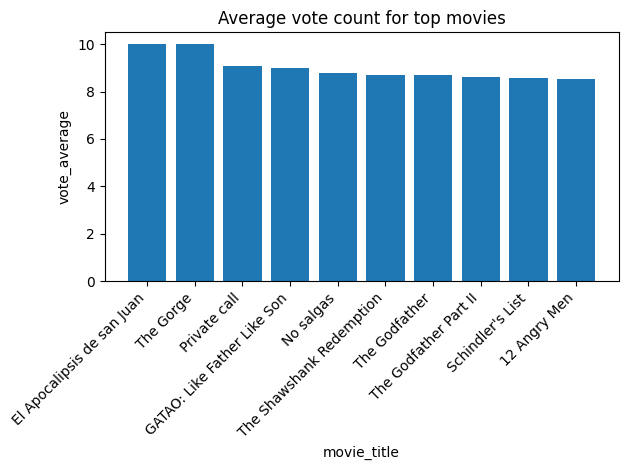

In [24]:
#Top 10 movies
top_movies = movies_data.sort_values(by = "vote_average", ascending = False).head(10)

plt.bar(top_movies["title"], top_movies["vote_average"])
plt.title("Average vote count for top movies")
plt.xlabel("movie_title")
plt.ylabel("vote_average")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [4]:
movies_data["release_year"] = pd.to_datetime(movies_data["release_date"]).dt.year
yearly_votes = movies_data.groupby('release_year')["vote_count"].sum().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(yearly_votes['release_year'], yearly_votes['vote_count'], color = "skyblue", width = 0.8)
plt.title("Vote Counts by Year")
plt.xlabel("Year")
plt.ylabel("Vote Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined

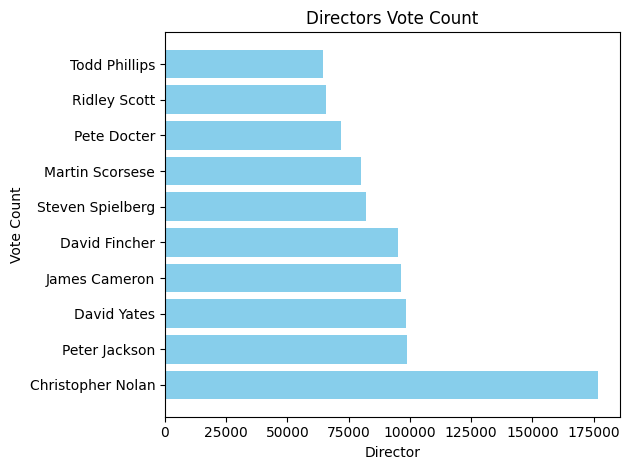

In [26]:
#Getting vote total number of vote count for each director and resetting index so that director doesnt become the index
def director_votes(movies_data):
    director_votes = movies_data.groupby('director')['vote_count'].sum().reset_index() 
    top_directors = director_votes.sort_values(by = "vote_count", ascending = False).head(10) #Showing only the top directors 

    plt.barh(top_directors['director'], top_directors['vote_count'], color = "skyblue")
    plt.xlabel("Director")
    plt.ylabel("Vote Count")
    plt.title("Directors Vote Count")
    plt.tight_layout()
    plt.show()
director_votes(movies_data)

In [27]:
movies_data['combined_features'] = movies_data['overview'] + ' ' +  movies_data['genres']*2  + movies_data['actors'] + movies_data['director'] 

In [28]:
movies_data = movies_data.dropna(subset = ['combined_features'])
movies_data = movies_data.drop(columns = ['release_date'])
movies_data['combined_features'].isna().sum()

0

In [29]:
movies_data.head(10)

,poster_path,id,title,vote_average,vote_count,overview,original_language,director,actors,genres,release_year,combined_features
0,/d8Ryb8AunYAuycVKDp5HpdWPKgC.jpg,939243,Sonic the Hedgehog 3,7.800,1642,"Sonic, Knuckles, and Tails reunite against a p...",en,Jeff Fowler,"Jim Carrey, Ben Schwartz, Keanu Reeves","Action, Science Fiction, Comedy, Family",2024.0,"Sonic, Knuckles, and Tails reunite against a p..."
1,/nrlfJoxP1EkBVE9pU62L287Jl4D.jpg,539972,Kraven the Hunter,6.600,1127,Kraven Kravinoff's complex relationship with h...,en,J.C. Chandor,"Aaron Taylor-Johnson, Ariana DeBose, Fred Hech...","Action, Adventure, Thriller",2024.0,Kraven Kravinoff's complex relationship with h...
2,/3L3l6LsiLGHkTG4RFB2aBA6BttB.jpg,993710,Back in Action,6.630,853,Fifteen years after vanishing from the CIA to ...,en,Seth Gordon,"Cameron Diaz, Jamie Foxx, McKenna Roberts","Action, Comedy",2025.0,Fifteen years after vanishing from the CIA to ...
3,/aLVkiINlIeCkcZIzb7XHzPYgO6L.jpg,1241982,Moana 2,7.219,1373,After receiving an unexpected call from her wa...,en,David G. Derrick Jr.,"Auliʻi Cravalho, Dwayne Johnson, Hualālai Chung","Animation, Adventure, Family, Comedy",2024.0,After receiving an unexpected call from her wa...
4,/xVS9XiO9upp2SnWx6KpBYb79hLR.jpg,1160956,Panda Plan,6.100,36,International action star Jackie Chan is invit...,zh,Zhang Luan,"Jackie Chan, Shi Ce, Wei Xiang","Action, Comedy",2024.0,International action star Jackie Chan is invit...
5,/jbOSUAWMGzGL1L4EaUF8K6zYFo7.jpg,762509,Mufasa: The Lion King,7.428,980,"Mufasa, a cub lost and alone, meets a sympathe...",en,Barry Jenkins,"Aaron Pierre, Kelvin Harrison Jr., Tiffany Boone","Adventure, Family, Animation",2024.0,"Mufasa, a cub lost and alone, meets a sympathe..."
6,/v313aUGmMNj6yNveaiQXysBmjVS.jpg,1249289,Alarum,5.836,140,Two married spies caught in the crosshairs of ...,en,Michael Polish,"Scott Eastwood, Sylvester Stallone, Willa Fitz...","Action, Crime, Thriller",2025.0,Two married spies caught in the crosshairs of ...
7,/TVvIyCsFCmLk9MRLbAZi4X8f32.jpg,1410082,Sniper: The Last Stand,6.600,71,To stop an arms dealer from unleashing a deadl...,en,Danishka Esterhazy,"Chad Michael Collins, Ryan Robbins, Sharon Taylor","Action, Thriller",2025.0,To stop an arms dealer from unleashing a deadl...
8,/5qGIxdEO841C0tdY8vOdLoRVrr0.jpg,426063,Nosferatu,6.658,1979,A gothic tale of obsession between a haunted y...,en,Robert Eggers,"Lily-Rose Depp, Nicholas Hoult, Bill Skarsgård","Horror, Fantasy",2024.0,A gothic tale of obsession between a haunted y...
9,/jTPBMPTgk9zOUGSkWcoOGbX8cTi.jpg,710295,Wolf Man,6.389,265,"With his marriage fraying, Blake persuades his...",en,Leigh Whannell,"Christopher Abbott, Julia Garner, Matilda Firth","Horror, Thriller",2025.0,"With his marriage fraying, Blake persuades his..."


In [30]:
tfidf = TfidfVectorizer(stop_words = "english")

#Applying TF-IDF on overview column
tfidf_matrix = tfidf.fit_transform(movies_data['combined_features'])

#Coverting tfidf matrix to a dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())

print(tfidf_df.head())

   000   10  101  108   11  11th   12   13   14   15  ...  zwart  álamo  \
0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
3  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
4  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   

   álvarez  álvaro  åkerlund  çesme  édouard  øvredal  žika  ʻohana  
0      0.0     0.0       0.0    0.0      0.0      0.0   0.0     0.0  
1      0.0     0.0       0.0    0.0      0.0      0.0   0.0     0.0  
2      0.0     0.0       0.0    0.0      0.0      0.0   0.0     0.0  
3      0.0     0.0       0.0    0.0      0.0      0.0   0.0     0.0  
4      0.0     0.0       0.0    0.0      0.0      0.0   0.0     0.0  

[5 rows x 11037 columns]


In [31]:
movies_data = movies_data.reset_index(drop = True)
cosine_sim = cosine_similarity(tfidf_df, tfidf_matrix)

def get_similar_movies(title, movies_data, cosine_sim, threshold=0.05):

    """"
    Retreives the similarity score of the selected movie and all the other movies in the dataset
    The list comprehension iterates over the cosine_sim scores and gets the index of the movie
    It then sorts the movies in descending order based on their similarity score and returns the top 5 movies
    """

    #Using .values for efficient comparison
    if title not in movies_data['title'].values:
        return f"'{title} not fount in the dataset'"

    # Get the index of the selected movie from the dataframe and create a list of tuples with movie index and similarity score
    idx = movies_data[movies_data['title'] == title].index[0]
    #Enumerate  assigns each movie(idx) its cosine similarity score
    sim_scores = list(enumerate(cosine_sim[idx]))
    #After we created a list of tuiples of movies with their sim_score now sorting them based on their sim_score in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #Getting the movies with sim_score > threshold
    sim_scores = [score for score in sim_scores if score[1] >= threshold]
    #top 5 movies 
    sim_scores = sim_scores[1:5]
    movie_indices = [i[0] for i in sim_scores]
    return movies_data['title'].iloc[movie_indices]

get_similar_movies("Inception", movies_data, cosine_sim)

675                 V/H/S/Beyond
687            The Fifth Element
578    Beverly Hills Cop: Axel F
322                     Iron Man
Name: title, dtype: object